In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, BertTokenizerFast, BertConfig, DebertaTokenizerFast, DebertaForSequenceClassification, DebertaConfig, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AutoTokenizer, DebertaTokenizer, DebertaV2Config, DebertaV2ForSequenceClassification, RobertaTokenizerFast, RobertaConfig, DebertaV2TokenizerFast, ConvBertConfig, ConvBertTokenizer, ConvBertForSequenceClassification
from huggingface_hub import notebook_login
from sklearn.preprocessing import LabelEncoder
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
notebook_login()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
# Constants
label_encoder = LabelEncoder()

basePath = "/content/drive/MyDrive/corpus_quechua"
labels = ['quz', 'quy', 'qvi', 'qug', 'quw']
num_labels = len(labels)

In [ ]:
def load_data():
  quechua_df = pd.read_csv(f"{basePath}/quechua_labeled_corpus.csv")
  return quechua_df

In [ ]:
def encode_labels(quechua_df: pd.DataFrame):
  quechua_df['label'] = quechua_df[labels].idxmax(axis=1)
  quechua_df['label'] = label_encoder.fit_transform(quechua_df['label'])
  return quechua_df

In [ ]:
def compute_metrics(pred):
  _labels = pred.label_ids
  predictions = np.argmax(pred.predictions, axis=1)

  precision, recall, f1, _ = precision_recall_fscore_support(_labels, predictions, average='weighted')
  acc = accuracy_score(_labels, predictions)

  return {
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
  }

In [ ]:
def plot_confusion_matrix(_trainer, val_dataset):
  outputs = _trainer.predict(val_dataset)
  y_preds = np.argmax(outputs.predictions, axis=1)
  y_true = outputs.label_ids

  cm = confusion_matrix(y_true, y_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
  disp.plot(cmap='Blues', xticks_rotation=45)

In [ ]:
def save_model(model, name):
  model.save_pretrained(f"{basePath}/classifiers/{name}")

In [ ]:
def save_tokenizer(tokenizer, name):
  tokenizer.save_pretrained(f"{basePath}/classifiers/{name}")

In [ ]:
class QuechuaDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
      'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
      'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
      'labels': torch.tensor(self.labels[idx])
    }

In [ ]:
def prepare_and_tokenize(tokenizer):
  df = load_data()
  df = encode_labels(df)

  train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Sentence"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42
  )

  train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
  val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

  return train_encodings, val_encodings, train_labels, val_labels

In [ ]:
def configurate_and_train(model, epochs, train_encodings, val_encodings, train_labels, val_labels):
  train_dataset = QuechuaDataset(train_encodings, train_labels)
  val_dataset = QuechuaDataset(val_encodings, val_labels)

  # Training args
  training_args = TrainingArguments(
      output_dir="./results",
      num_train_epochs=epochs,
      per_device_train_batch_size=32,
      per_device_eval_batch_size=32,
      eval_strategy="epoch",
      save_strategy="epoch",
      logging_dir="./logs",
      logging_steps=10,
      load_best_model_at_end=True,
      metric_for_best_model="eval_loss"
  )

  # Training
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
  )

  trainer.train()

  return model, trainer, val_dataset

In [ ]:
EPOCHS = 3
HIDDEN_LAYERS = 6
HIDDEN_SIZE = 768
INTERMEDIATE_SIZE = 768
NUM_ATTENTION_HEADS = 6
NUM_LABELS = num_labels

# Default Tokenizer

## BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

train_encodings, val_encodings, train_labels, val_labels = prepare_and_tokenize(tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
config = BertConfig.from_pretrained("google-bert/bert-base-uncased")

config.num_hidden_layers = HIDDEN_LAYERS
config.hidden_size = HIDDEN_SIZE
config.intermediate_size = INTERMEDIATE_SIZE
config.num_attention_heads = NUM_ATTENTION_HEADS
config.num_labels = NUM_LABELS

# Model
model = BertForSequenceClassification(config)

In [ ]:
model, trainer, val_dataset = configurate_and_train(model, EPOCHS, train_encodings, val_encodings, train_labels, val_labels)

save_model(model, "BERT_MODEL")
save_tokenizer(tokenizer, "BERT_TOK")

plot_confusion_matrix(trainer, val_dataset)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cw-aranibar-solaligue (cw-aranibar-solaligue-universidad-cat-lica-san-pablo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.061100,0.101473,0.962769,0.962727,0.963370,0.962769
2,0.046000,0.076355,0.970561,0.970563,0.970786,0.970561
3,0.043100,0.079662,0.973249,0.973247,0.973265,0.973249


TypeError: plot_confusion_matrix() missing 1 required positional argument: 'val_dataset'

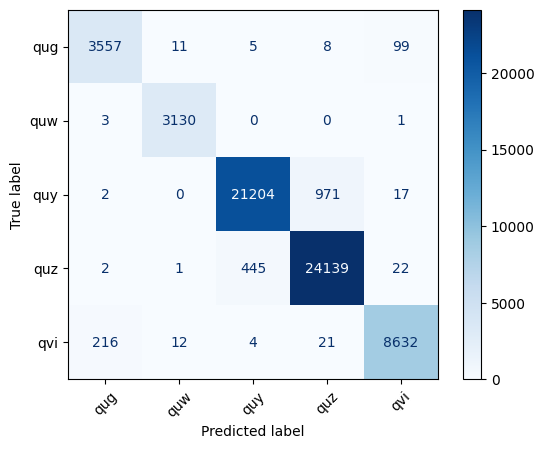

In [ ]:
plot_confusion_matrix(trainer, val_dataset)

## DeBERTa

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

train_encodings, val_encodings, train_labels, val_labels = prepare_and_tokenize(tokenizer)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [ ]:
config = DebertaConfig.from_pretrained("microsoft/deberta-base")

config.num_hidden_layers = HIDDEN_LAYERS
config.hidden_size = HIDDEN_SIZE
config.intermediate_size = INTERMEDIATE_SIZE
config.num_attention_heads = NUM_ATTENTION_HEADS
config.num_labels = NUM_LABELS

# Model
model = DebertaForSequenceClassification(config)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.040900,0.074093,0.971233,0.971170,0.971521,0.971233
2,0.031400,0.055933,0.978689,0.978668,0.978848,0.978689
3,0.053000,0.052654,0.980673,0.980667,0.980669,0.980673


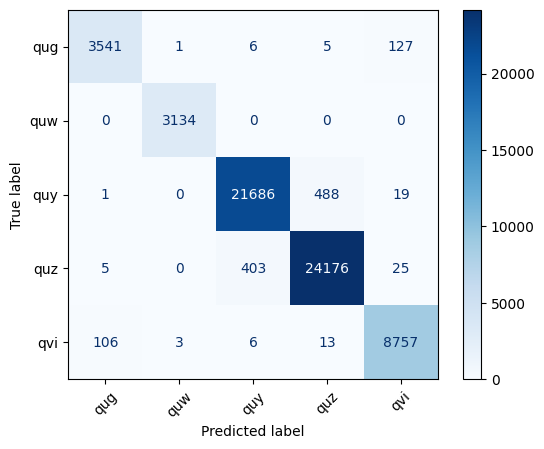

In [ ]:
model, trainer, val_dataset = configurate_and_train(model, EPOCHS, train_encodings, val_encodings, train_labels, val_labels)

save_model(model, "DEBERTA_MODEL")
save_tokenizer(tokenizer, "DEBERTA_TOK")

plot_confusion_matrix(trainer, val_dataset)

## RoBERTa

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

train_encodings, val_encodings, train_labels, val_labels = prepare_and_tokenize(tokenizer)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
config = RobertaConfig.from_pretrained("FacebookAI/roberta-base")

config.num_hidden_layers = HIDDEN_LAYERS
config.hidden_size = HIDDEN_SIZE
config.intermediate_size = INTERMEDIATE_SIZE
config.num_attention_heads = NUM_ATTENTION_HEADS
config.num_labels = NUM_LABELS

# Model
model = RobertaForSequenceClassification(config)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.055600,0.123083,0.954817,0.954563,0.956117,0.954817
2,0.064500,0.082947,0.970865,0.970840,0.970885,0.970865
3,0.045900,0.078984,0.973953,0.973946,0.973943,0.973953


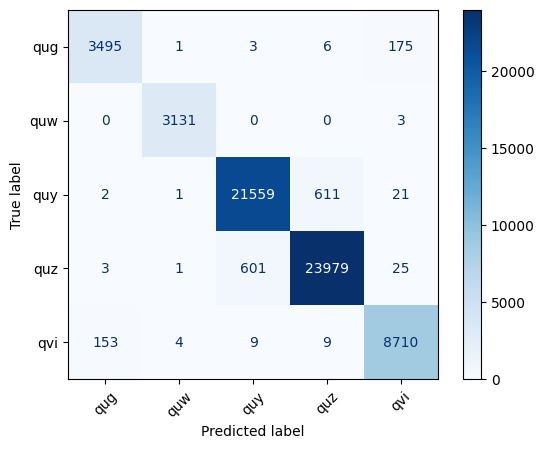

In [ ]:
model, trainer, val_dataset = configurate_and_train(model, EPOCHS, train_encodings, val_encodings, train_labels, val_labels)

save_model(model, "ROBERTA_MODEL")
save_tokenizer(tokenizer, "ROBERTA_TOK")

plot_confusion_matrix(trainer, val_dataset)

## ConvBERT

In [ ]:
tokenizer = ConvBertTokenizer.from_pretrained("YituTech/conv-bert-base")

train_encodings, val_encodings, train_labels, val_labels = prepare_and_tokenize(tokenizer)

In [ ]:
config = ConvBertConfig.from_pretrained("YituTech/conv-bert-base")

config.num_hidden_layers = HIDDEN_LAYERS
config.hidden_size = HIDDEN_SIZE
config.intermediate_size = INTERMEDIATE_SIZE
config.num_attention_heads = NUM_ATTENTION_HEADS
config.num_labels = NUM_LABELS

# Model
model = ConvBertForSequenceClassification(config)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.050000,0.089605,0.966993,0.966908,0.968339,0.966993
2,0.028600,0.057919,0.977969,0.977977,0.978095,0.977969
3,0.035100,0.058061,0.980289,0.980285,0.980285,0.980289


Saving vocabulary to /content/drive/MyDrive/corpus_quechua/classifiers/CONVBERT_TOK/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/drive/MyDrive/corpus_quechua/classifiers/CONVBERT_TOK/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/drive/MyDrive/corpus_quechua/classifiers/CONVBERT_TOK/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/drive/MyDrive/corpus_quechua/classifiers/CONVBERT_TOK/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/drive/MyDrive/corpus_quechua/classifiers/CONVBERT_TOK/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /content/drive/MyDrive/corpus_quechua/classifiers

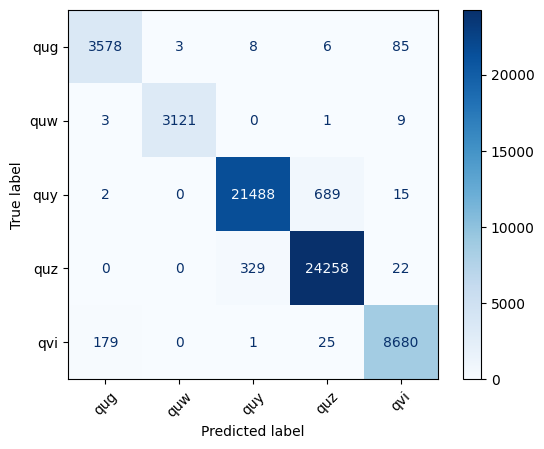

In [ ]:
model, trainer, val_dataset = configurate_and_train(model, EPOCHS, train_encodings, val_encodings, train_labels, val_labels)

save_model(model, "CONVBERT_MODEL")
save_tokenizer(tokenizer, "CONVBERT_TOK")

plot_confusion_matrix(trainer, val_dataset)

# Custom Tokenizer

## DeBERTa & RoBERTa with BPE

## DeBERTa

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained(f"{basePath}/tokenizers/bpe/deberta")

train_encodings, val_encodings, train_labels, val_labels = prepare_and_tokenize(tokenizer)

In [ ]:
config = DebertaConfig.from_pretrained("microsoft/deberta-base")

config.num_hidden_layers = HIDDEN_LAYERS
config.hidden_size = HIDDEN_SIZE
config.intermediate_size = INTERMEDIATE_SIZE
config.num_attention_heads = NUM_ATTENTION_HEADS
config.num_labels = NUM_LABELS

# Model
model = DebertaForSequenceClassification(config)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.045000,0.044041,0.983889,0.983885,0.983940,0.983889
2,0.026700,0.045425,0.985920,0.985917,0.985922,0.985920
3,0.011600,0.054147,0.986480,0.986477,0.986481,0.986480


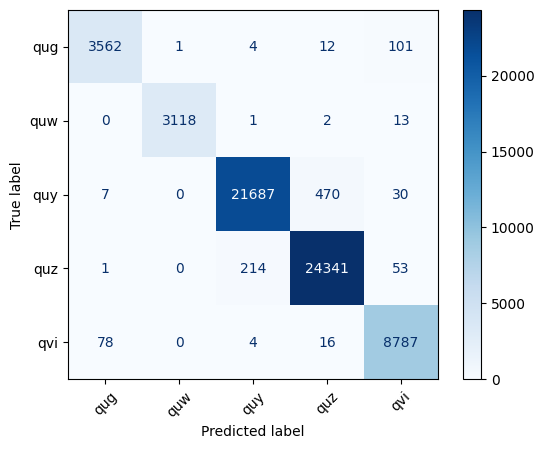

In [ ]:
model, trainer, val_dataset = configurate_and_train(model, EPOCHS, train_encodings, val_encodings, train_labels, val_labels)

save_model(model, "DEBERTA_CUSTOM_MODEL")
save_tokenizer(tokenizer, "DEBERTA_CUSTOM_TOK")

plot_confusion_matrix(trainer, val_dataset)

## RoBERTa

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(f"{basePath}/tokenizers/bpe/roberta")

train_encodings, val_encodings, train_labels, val_labels = prepare_and_tokenize(tokenizer)

In [ ]:
config = RobertaConfig.from_pretrained("FacebookAI/roberta-base")

config.num_hidden_layers = HIDDEN_LAYERS
config.hidden_size = HIDDEN_SIZE
config.intermediate_size = INTERMEDIATE_SIZE
config.num_attention_heads = NUM_ATTENTION_HEADS
config.num_labels = NUM_LABELS

# Model
model = RobertaForSequenceClassification(config)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.083100,0.050214,0.981329,0.981325,0.981520,0.981329
2,0.026900,0.046528,0.986048,0.986056,0.986084,0.986048
3,0.012200,0.055281,0.986496,0.986494,0.986500,0.986496


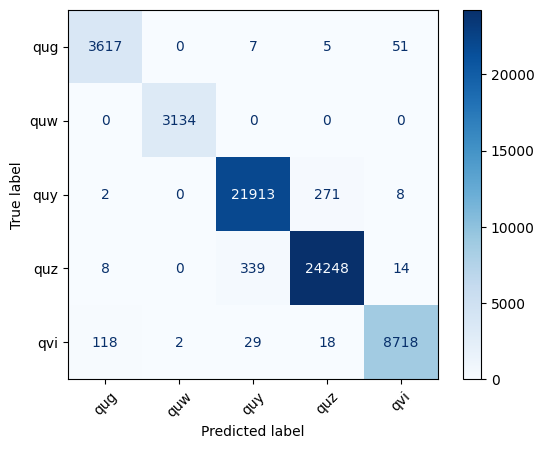

In [ ]:
model, trainer, val_dataset = configurate_and_train(model, EPOCHS, train_encodings, val_encodings, train_labels, val_labels)

save_model(model, "ROBERTA_CUSTOM_MODEL")
save_tokenizer(tokenizer, "ROBERTA_CUSTOM_TOK")

plot_confusion_matrix(trainer, val_dataset)

## BERT & ConvBERT with WordPiece

## BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained(f"{basePath}/tokenizers/wordpiece")

train_encodings, val_encodings, train_labels, val_labels = prepare_and_tokenize(tokenizer)

In [ ]:
config = BertConfig.from_pretrained("google-bert/bert-base-uncased")

config.num_hidden_layers = HIDDEN_LAYERS
config.hidden_size = HIDDEN_SIZE
config.intermediate_size = INTERMEDIATE_SIZE
config.num_attention_heads = NUM_ATTENTION_HEADS
config.num_labels = NUM_LABELS

# Model
model = BertForSequenceClassification(config)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.044100,0.063231,0.980113,0.980064,0.980384,0.980113
2,0.034100,0.052726,0.984736,0.984743,0.984769,0.984736
3,0.007500,0.057534,0.985552,0.985550,0.985553,0.985552


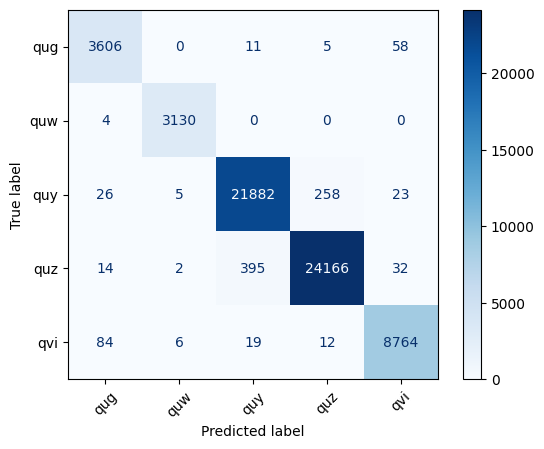

In [ ]:
model, trainer, val_dataset = configurate_and_train(model, EPOCHS, train_encodings, val_encodings, train_labels, val_labels)

save_model(model, "BERT_CUSTOM_MODEL")
save_tokenizer(tokenizer, "BERT_CUSTOM_TOK")

plot_confusion_matrix(trainer, val_dataset)

## ConvBERT

In [ ]:
tokenizer = ConvBertTokenizer.from_pretrained(f"{basePath}/tokenizers/wordpiece")

train_encodings, val_encodings, train_labels, val_labels = prepare_and_tokenize(tokenizer)

In [ ]:
config = ConvBertConfig.from_pretrained("YituTech/conv-bert-base")

config.num_hidden_layers = HIDDEN_LAYERS
config.hidden_size = HIDDEN_SIZE
config.intermediate_size = INTERMEDIATE_SIZE
config.num_attention_heads = NUM_ATTENTION_HEADS
config.num_labels = NUM_LABELS

# Model
model = ConvBertForSequenceClassification(config)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.052400,0.066458,0.978609,0.978601,0.979101,0.978609
2,0.029100,0.053429,0.984832,0.984834,0.984849,0.984832
3,0.008000,0.056651,0.985936,0.985933,0.985932,0.985936


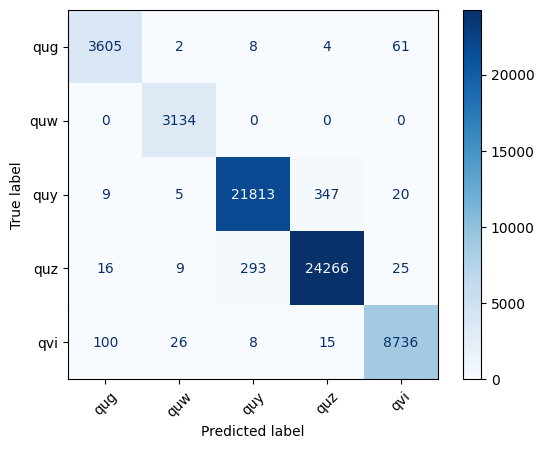

In [ ]:
model, trainer, val_dataset = configurate_and_train(model, EPOCHS, train_encodings, val_encodings, train_labels, val_labels)

save_model(model, "CONVBERT_CUSTOM_MODEL")
save_tokenizer(tokenizer, "CONVBERT_CUSTOM_TOK")

plot_confusion_matrix(trainer, val_dataset)

# Results

In [ ]:
results = [
    {
        "model": "BERT + Default Tokenizer",
        "data": [
            {"epoch": 1, "results": {"train_loss": 0.0611, "val_loss": 0.101473, "accuracy": 0.962769, "f1": 0.962727, "precision": 0.96337, "recall": 0.962769}},
            {"epoch": 2, "results": {"train_loss": 0.046, "val_loss": 0.076355, "accuracy": 0.970561, "f1": 0.970563, "precision": 0.970786, "recall": 0.970561}},
            {"epoch": 3, "results": {"train_loss": 0.0431, "val_loss": 0.079662, "accuracy": 0.973249, "f1": 0.973247, "precision": 0.973265, "recall": 0.973249}},
        ],
    },
    {
        "model": "DeBERTa + Default Tokenizer",
        "data": [
            {"epoch": 1, "results": {"train_loss": 0.0409, "val_loss": 0.074093, "accuracy": 0.971233, "f1": 0.97117, "precision": 0.971521, "recall": 0.971233}},
            {"epoch": 2, "results": {"train_loss": 0.0314, "val_loss": 0.055933, "accuracy": 0.978689, "f1": 0.978668, "precision": 0.978848, "recall": 0.978689}},
            {"epoch": 3, "results": {"train_loss": 0.053, "val_loss": 0.052654, "accuracy": 0.980673, "f1": 0.980667, "precision": 0.980669, "recall": 0.980673}},
        ],
    },
    {
        "model": "RoBERTa + Default Tokenizer",
        "data": [
            {"epoch": 1, "results": {"train_loss": 0.0556, "val_loss": 0.123083, "accuracy": 0.954817, "f1": 0.954563, "precision": 0.956117, "recall": 0.954817}},
            {"epoch": 2, "results": {"train_loss": 0.0645, "val_loss": 0.082947, "accuracy": 0.970865, "f1": 0.97084, "precision": 0.970885, "recall": 0.970865}},
            {"epoch": 3, "results": {"train_loss": 0.0459, "val_loss": 0.078984, "accuracy": 0.973953, "f1": 0.973946, "precision": 0.973943, "recall": 0.973953}},
        ],
    },
    {
        "model": "ConvBERT + Default Tokenizer",
        "data": [
            {"epoch": 1, "results": {"train_loss": 0.05, "val_loss": 0.089605, "accuracy": 0.966993, "f1": 0.966908, "precision": 0.968339, "recall": 0.966993}},
            {"epoch": 2, "results": {"train_loss": 0.0286, "val_loss": 0.057919, "accuracy": 0.977969, "f1": 0.977977, "precision": 0.978095, "recall": 0.977969}},
            {"epoch": 3, "results": {"train_loss": 0.0351, "val_loss": 0.058061, "accuracy": 0.980289, "f1": 0.980285, "precision": 0.980285, "recall": 0.980289}},
        ],
    },
    {
        "model": "BERT + Custom Tokenizer",
        "data": [
            {"epoch": 1, "results": {"train_loss": 0.0441, "val_loss": 0.063231, "accuracy": 0.980113, "f1": 0.980064, "precision": 0.980384, "recall": 0.980113}},
            {"epoch": 2, "results": {"train_loss": 0.0341, "val_loss": 0.052726, "accuracy": 0.984736, "f1": 0.984743, "precision": 0.984769, "recall": 0.984736}},
            {"epoch": 3, "results": {"train_loss": 0.0075, "val_loss": 0.057534, "accuracy": 0.985552, "f1": 0.98555, "precision": 0.985553, "recall": 0.985552}},
        ],
    },
    {
        "model": "DeBERTa + Custom Tokenizer",
        "data": [
            {"epoch": 1, "results": {"train_loss": 0.045, "val_loss": 0.044041, "accuracy": 0.983889, "f1": 0.983885, "precision": 0.98394, "recall": 0.983889}},
            {"epoch": 2, "results": {"train_loss": 0.0267, "val_loss": 0.045425, "accuracy": 0.98592, "f1": 0.985917, "precision": 0.985922, "recall": 0.98592}},
            {"epoch": 3, "results": {"train_loss": 0.0116, "val_loss": 0.054147, "accuracy": 0.98648, "f1": 0.986477, "precision": 0.986481, "recall": 0.98648}},
        ],
    },
    {
        "model": "RoBERTa + Custom Tokenizer",
        "data": [
            {"epoch": 1, "results": {"train_loss": 0.0831, "val_loss": 0.050214, "accuracy": 0.981329, "f1": 0.981325, "precision": 0.98152, "recall": 0.981329}},
            {"epoch": 2, "results": {"train_loss": 0.0269, "val_loss": 0.046528, "accuracy": 0.986048, "f1": 0.986056, "precision": 0.986084, "recall": 0.986048}},
            {"epoch": 3, "results": {"train_loss": 0.0122, "val_loss": 0.055281, "accuracy": 0.986496, "f1": 0.986494, "precision": 0.9865, "recall": 0.986496}},
        ],
    },
    {
        "model": "ConvBERT + Custom Tokenizer",
        "data": [
            {"epoch": 1, "results": {"train_loss": 0.0524, "val_loss": 0.066458, "accuracy": 0.978609, "f1": 0.978601, "precision": 0.979101, "recall": 0.978609}},
            {"epoch": 2, "results": {"train_loss": 0.0291, "val_loss": 0.053429, "accuracy": 0.984832, "f1": 0.984834, "precision": 0.984849, "recall": 0.984832}},
            {"epoch": 3, "results": {"train_loss": 0.008, "val_loss": 0.056651, "accuracy": 0.985936, "f1": 0.985933, "precision": 0.985932, "recall": 0.985936}},
        ],
    },
]

In [ ]:
rows = []
for r in results:
    for entry in r["data"]:
        rows.append({
            "Model": r["model"],
            "Epoch": entry["epoch"],
            "F1": entry["results"]["f1"]
        })

df = pd.DataFrame(rows)

In [ ]:
df.head()

,Model,Epoch,F1
0,BERT + Default Tokenizer,1,0.962727
1,BERT + Default Tokenizer,2,0.970563
2,BERT + Default Tokenizer,3,0.973247
3,DeBERTa + Default Tokenizer,1,0.971170
4,DeBERTa + Default Tokenizer,2,0.978668


In [ ]:
def plot_models(df, filter_text, title, figsize=(10, 6)):
    filtered = df[df["Model"].str.contains(filter_text)]
    plt.figure(figsize=figsize)
    sns.lineplot(data=filtered, x="Epoch", y="F1", hue="Model", marker="o")
    plt.ylim(0.94, 0.99)
    plt.title(title)
    plt.ylabel("F1 Score")
    plt.xlabel("Epoch")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

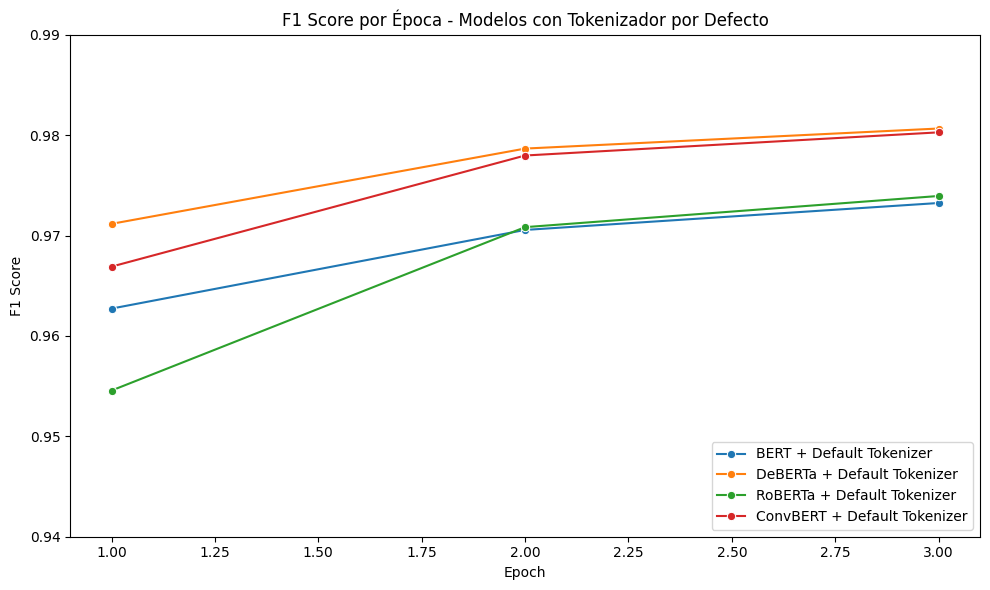

In [ ]:
plot_models(df, "Default", "F1 Score por Época - Modelos con Tokenizador por Defecto")

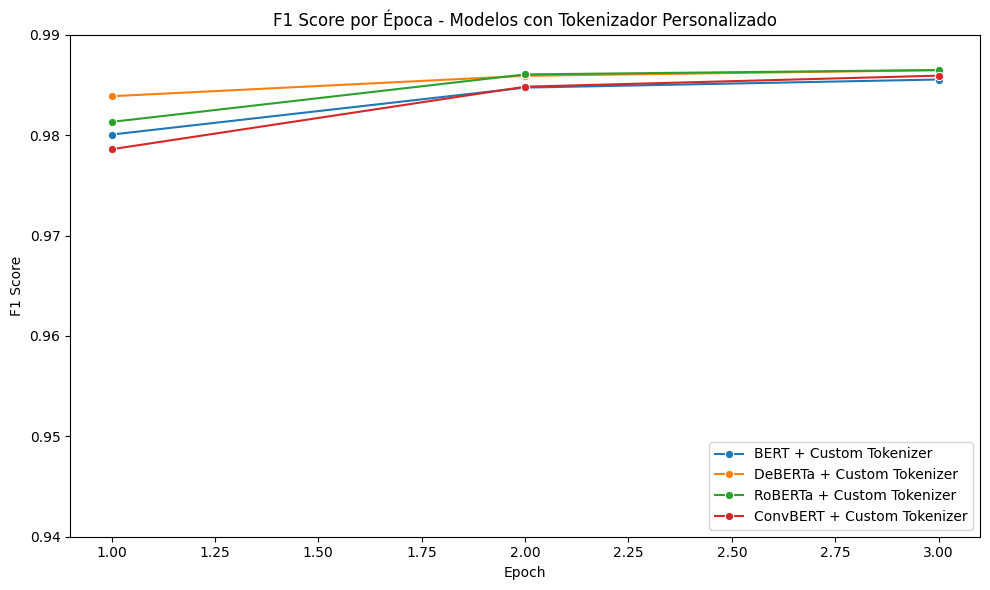

In [ ]:
plot_models(df, "Custom", "F1 Score por Época - Modelos con Tokenizador Personalizado")

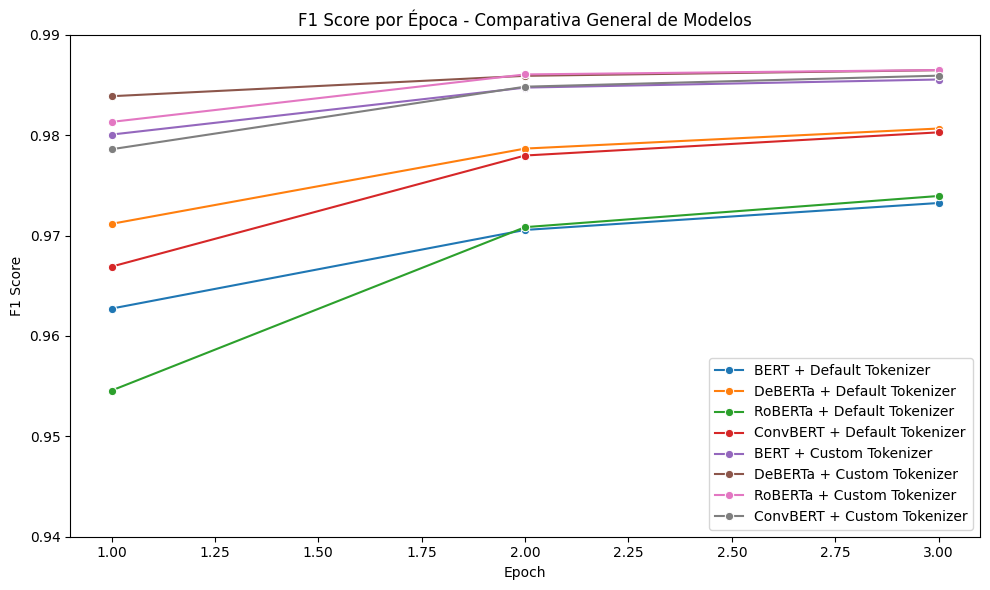

In [ ]:
plot_models(df, "", "F1 Score por Época - Comparativa General de Modelos")